In [15]:

import os
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import torch.utils
import torch.utils.data
from dataset_raw import DRIVEDataset, apply_fov
import torchvision
from config import MODEL, DEVICE
from train_utils import calculate_metrics
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

if not os.path.exists('models'):
    os.makedirs('models')

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    ToTensorV2(),
])
 
test_transforms = A.Compose([
    ToTensorV2(),
])

size=(512,512)
batch_size=1

data_dir = "archive\\DRIVE\\training\\images"
identifiers = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

train_identifiers, val_identifiers = train_test_split(identifiers, test_size=10, random_state=42)


train_data=DRIVEDataset(root_dir="archive\\DRIVE\\training",identifiers=train_identifiers,size=size,transform=train_transforms)
validation_data=DRIVEDataset(root_dir="archive\\DRIVE\\training",identifiers=val_identifiers,size=size,transform=test_transforms)
test_data=DRIVEDataset(root_dir="archive\\DRIVE\\test",size=size,transform=test_transforms,testing=True)


training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Assuming `dataset` is your validation dataset and `specific_image_index` is the index of the image you want to print
specific_image_index = 0  # Example index, replace with the actual index of your specific image
specific_dataset = torch.utils.data.Subset(validation_data, [specific_image_index])
specific_loader = torch.utils.data.DataLoader(specific_dataset, batch_size=1)


In [16]:
img, mask, fov = next(iter(training_loader))
# img, mask, fov = img.to(DEVICE), mask.to(DEVICE), fov.to(DEVICE)
outputs = MODEL(img)
outputs.dtype, mask.dtype, fov.dtype, img.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [17]:
img.min(), img.max(), mask.min(), mask.max(), outputs.min(), outputs.max()

(tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(-6.4014, grad_fn=<MinBackward1>),
 tensor(3.4496, grad_fn=<MaxBackward1>))

In [18]:
outputs = (torch.sigmoid(outputs) > 0.5).int()
mask = mask.int()

In [19]:
calculate_metrics(mask, outputs)

{'dice': array(0.39191055, dtype=float32),
 'auc': 0.44747392739524683,
 'miou': array(0.09592219, dtype=float32)}

In [20]:
img,mask,_=next(iter(training_loader))
print(img.type(),mask.type())
img.shape,mask.shape

torch.FloatTensor torch.FloatTensor


(torch.Size([1, 3, 512, 512]), torch.Size([1, 1, 512, 512]))

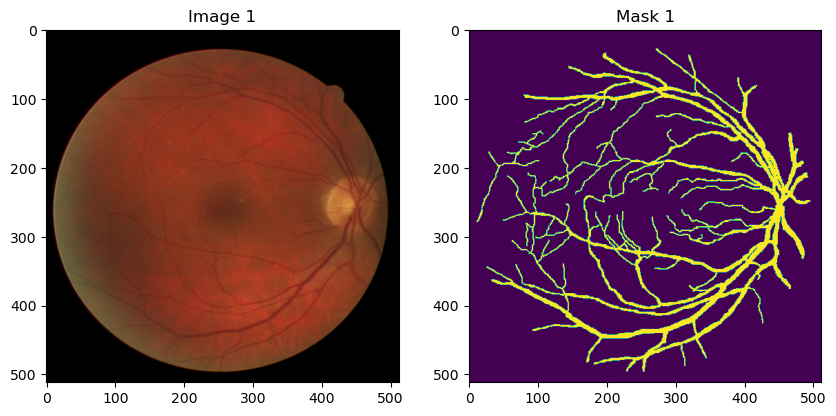

In [21]:
from matplotlib import pyplot as plt

for batch_idx, (images, masks, _) in enumerate(training_loader):
    batch_size = len(images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(10, 5 * batch_size))  # Adjusting figure size based on batch size
    
    for i in range(batch_size):
        img = images[i].numpy().transpose((1, 2, 0))  # Adjusting dimensions for plotting if necessary
        mask = masks[i].numpy().transpose((1, 2, 0))  # Adjusting dimensions for plotting if necessary
        
        if batch_size > 1:
            axs[i, 0].imshow(img)
            axs[i, 1].imshow(mask)
            axs[i, 0].set_title(f"Image {i+1}")
            axs[i, 1].set_title(f"Mask {i+1}")
        else:
            axs[0].imshow(img)
            axs[1].imshow(mask)
            axs[0].set_title(f"Image {i+1}")
            axs[1].set_title(f"Mask {i+1}")
    
    plt.show()
    break


In [22]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['vessel']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
MODE=smp.losses.constants.BINARY_MODE

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=ENCODER_WEIGHTS,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [23]:
dice_loss = smp.losses.DiceLoss(mode=MODE,from_logits=True)


y_pred = torch.rand(1, 1, 256, 256)  # Dummy predicted segmentation map
y_true = torch.randint(0, 2, (1, 1, 256, 256)).float()  # Dummy ground truth map

# Calculate loss
loss = dice_loss(y_pred, y_true)

print(f'Dice Loss: {loss.item()}')

Dice Loss: 0.44754570722579956


In [24]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [26]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

model.to(device)  # Move model to the appropriate device


def train_one_epoch(epoch_index, tb_writer: SummaryWriter):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        image, mask, fov  = data
        # image = image.float()
        image, mask, fov = image.to(device), mask.to(device), fov.to(device)  # Move data to the appropriate device


        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(image)
        # print(torch.sum(outputs.eq(0)).item())
        # outputs = apply_fov(outputs, fov)
        # print(torch.sum(outputs.eq(0)).item())

        # Compute the loss and its gradients
        loss = dice_loss(outputs, mask)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_size == batch_size - 1:  # Adjust condition to dynamically match the batch size
            last_loss = running_loss / batch_size  # Dynamically calculate loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

def save_one_img(epoch_number ,loader: torch.utils.data.DataLoader, tb_writer: SummaryWriter):
    # Extract the image and mask from the specific_loader
    vimg_print, vmask_print, _ = next(iter(loader))
    vimg_print, vmask_print = vimg_print.to(device), vmask_print.to(device)
    voutputs_print = model(vimg_print)

    # Convert the tensors to grid images for the specific image
    vimg_grid_print = torchvision.utils.make_grid(vimg_print)
    vmask_grid_print = torchvision.utils.make_grid(vmask_print)
    voutputs_grid_print = torchvision.utils.make_grid(torch.sigmoid(voutputs_print) > 0.5)  # Assuming binary classification

    # Log the images for the specific image
    tb_writer.add_image('Validation/Image', vimg_grid_print, epoch_number)
    tb_writer.add_image('Validation/Mask', vmask_grid_print, epoch_number)
    tb_writer.add_image('Validation/Output', voutputs_grid_print, epoch_number)

In [27]:
epoch_number = 0

EPOCHS = 25

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vimg,vmask, _ = vdata
            vimg, vmask = vimg.to(device), vmask.to(device)  # Move data to the appropriate device

            voutputs = model(vimg)
            vloss = dice_loss(voutputs, vmask)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    save_one_img(epoch_number, specific_loader, writer)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models\\model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

writer.close()

EPOCH 1:
  batch 1 loss: 0.8046349883079529
  batch 2 loss: 0.7992615699768066
  batch 3 loss: 0.7283073663711548
  batch 4 loss: 0.742202877998352
  batch 5 loss: 0.6545814275741577
  batch 6 loss: 0.6078791618347168
  batch 7 loss: 0.5982509851455688
  batch 8 loss: 0.6003661155700684
  batch 9 loss: 0.5797581672668457
  batch 10 loss: 0.5562547445297241
LOSS train 0.5562547445297241 valid 0.7630175948143005
EPOCH 2:
  batch 1 loss: 0.5676119923591614
  batch 2 loss: 0.6206693649291992
  batch 3 loss: 0.5289711952209473
  batch 4 loss: 0.5184436440467834
  batch 5 loss: 0.5995868444442749
  batch 6 loss: 0.5273711681365967
  batch 7 loss: 0.5085674524307251
  batch 8 loss: 0.4871324300765991
  batch 9 loss: 0.45185500383377075
  batch 10 loss: 0.4287670850753784
LOSS train 0.4287670850753784 valid 0.618826150894165
EPOCH 3:
  batch 1 loss: 0.47108691930770874
  batch 2 loss: 0.41324353218078613
  batch 3 loss: 0.5245640277862549
  batch 4 loss: 0.43001610040664673
  batch 5 loss: 0.3

In [28]:
# saved_model = model
# saved_model.load_state_dict(torch.load("model_20240710_003512_4"))

In [29]:
def compute_tp_fp_fn_tn(outputs, mask, threshold=0.5):
    # Binarize predictions and mask based on the threshold
    outputs_bin = (outputs > threshold).astype(int)
    mask_bin = (mask > threshold).astype(int)
    
    # Compute TP, FP, FN, TN
    tp = np.sum((outputs_bin == 1) & (mask_bin == 1))
    fp = np.sum((outputs_bin == 1) & (mask_bin == 0))
    fn = np.sum((outputs_bin == 0) & (mask_bin == 1))
    tn = np.sum((outputs_bin == 0) & (mask_bin == 0))
    
    return tp, fp, fn, tn

def compute_metrics(tp, fp, fn, tn, beta=1):
    # Compute precision, recall, and F-beta score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0
    
    # Compute IOU
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Compute accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    
    return iou, fbeta, accuracy, recall


In [30]:
def evaluate_model(model, validation_loader):
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            img,mask, _ = data
            img, mask = img.to(device).float(), mask.to(device)

            outputs = model(img).cpu().numpy()  # Move outputs back to CPU for numpy conversion
            mask = mask.cpu().numpy()

            # Assuming outputs and mask are numpy arrays
            tp, fp, fn, tn = compute_tp_fp_fn_tn(outputs, mask, threshold=0.5)
            print(tp, fp, fn, tn)
            iou_score, f1_score, accuracy, recall = compute_metrics(tp, fp, fn, tn, beta=1)
            f2_score, _, _, _ = compute_metrics(tp, fp, fn, tn, beta=2)

            print(f"IOU: {iou_score}, F1: {f1_score}, F2: {f2_score}, Accuracy: {accuracy}, Recall: {recall}")

In [31]:
# Show sample output

import matplotlib.pyplot as plt

def show_sample_output(model, test_loader):
    img, mask, _ = next(iter(test_loader))
    img, mask = img.to(device), mask.to(device)
    outputs = model(img)
    outputs = torch.sigmoid(outputs) > 0.5
    outputs = outputs.cpu().numpy().squeeze()
    mask = mask.cpu().numpy().squeeze()
    img = img.cpu().numpy().squeeze()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img.squeeze().transpose(1, 2, 0))
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Ground Truth')
    ax[1].axis('off')
    ax[2].imshow(outputs, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    plt.show()


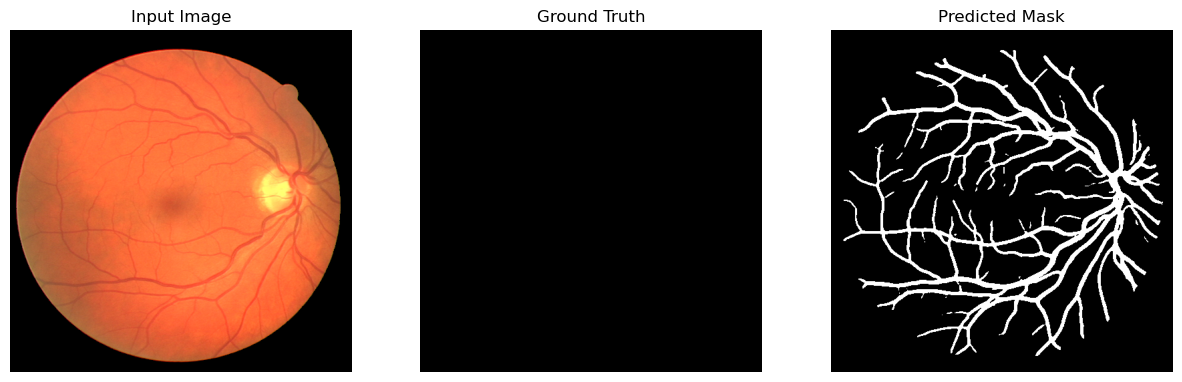

In [32]:
show_sample_output(model, test_loader)

In [33]:
evaluate_model(model, validation_loader)

27864 8968 4670 220642
IOU: 0.6713893306346682, F1: 0.803390710146181, F2: 0.6713893306346682, Accuracy: 0.9479751586914062, Recall: 0.8564578594700928
24260 5490 4226 228168
IOU: 0.7140334353661408, F1: 0.8331616182430113, F2: 0.7140334353661408, Accuracy: 0.9629364013671875, Recall: 0.8516464228041846
21847 2595 8827 228875
IOU: 0.6566773873576002, F1: 0.7927643515494593, F2: 0.6566773873576002, Accuracy: 0.9564285278320312, Recall: 0.7122318575992698
30203 2376 12716 216849
IOU: 0.6668064907826471, F1: 0.800100664918276, F2: 0.6668064907826471, Accuracy: 0.9424285888671875, Recall: 0.7037209627437732
24888 3287 9972 223997
IOU: 0.6524235195428212, F1: 0.7896565400174507, F2: 0.6524235195428212, Accuracy: 0.9494209289550781, Recall: 0.7139414802065405
25424 4714 6971 225035
IOU: 0.6851168180225822, F1: 0.8131386627860488, F2: 0.6851168180225822, Accuracy: 0.9554252624511719, Recall: 0.7848124710603488
20427 1983 10683 229051
IOU: 0.6172604478288459, F1: 0.763340807174888, F2: 0.61726

In [34]:
np.set_printoptions(threshold=np.inf)
print(outputs.max(),outputs.min())

tensor(1, dtype=torch.int32) tensor(0, dtype=torch.int32)
